In [1]:
from utils.data_utils import load_corpus_

corpus, title2id = load_corpus_('data/corpus/hotpot-paragraph-5.tsv', for_hotpot=True, require_hyperlinks=True)

In [2]:
print(len(corpus))
print(len(title2id))

5232080
5232080


In [3]:
from html import unescape
import json

from utils.data_utils import get_valid_links

sp_ids = set()
hard_neg_ids = set()
hard_neg_nums = []
in_neighbor_nums = []
out_neighbor_nums = []

In [4]:
is_strict = True
split = 'train'
with open(f"data/hotpot-step-{split}{'.strict' if is_strict else ''}.refined.1.jsonl") as f:
    for line in f:
        example = json.loads(line)
        _sps = []
        for sp_title in example['sp_facts']:
            sp_id = title2id[sp_title]
            sp_ids.add(sp_id)
            _sps.append(corpus[sp_id])
        in_neighbors = 0
        out_neighbors = 0
        for p_id in example['hard_negs']:
            hard_neg_ids.add(p_id)
            if len(set(example['sp_facts'].keys()) & set(get_valid_links(corpus[p_id], is_strict).keys())) > 0:
                in_neighbors += 1
            if unescape(corpus[p_id]['title']) in (set(get_valid_links(_sps[0], is_strict).keys()) | set(get_valid_links(_sps[0], is_strict).keys())):
                out_neighbors += 1
        hard_neg_nums.append(len(example['hard_negs']))
        in_neighbor_nums.append(in_neighbors)
        out_neighbor_nums.append(out_neighbors)

In [5]:
print(len(sp_ids))
print(len(hard_neg_ids))

105570
742142


In [6]:
is_strict = True
split = 'dev'
with open(f"data/hotpot-step-{split}{'.strict' if is_strict else ''}.refined.1.jsonl") as f:
    for line in f:
        example = json.loads(line)
        _sps = []
        for sp_title in example['sp_facts']:
            sp_id = title2id[sp_title]
            sp_ids.add(sp_id)
            _sps.append(corpus[sp_id])
        in_neighbors = 0
        out_neighbors = 0
        for p_id in example['hard_negs']:
            hard_neg_ids.add(p_id)
            if len(set(example['sp_facts'].keys()) & set(get_valid_links(corpus[p_id], is_strict).keys())) > 0:
                in_neighbors += 1
            if unescape(corpus[p_id]['title']) in (set(get_valid_links(_sps[0], is_strict).keys()) | set(get_valid_links(_sps[0], is_strict).keys())):
                out_neighbors += 1
        hard_neg_nums.append(len(example['hard_negs']))
        in_neighbor_nums.append(in_neighbors)
        out_neighbor_nums.append(out_neighbors)

In [7]:
print(len(sp_ids))
print(len(hard_neg_ids))

111140
782771


In [8]:
train_dev_p_ids = sp_ids | hard_neg_ids
print(len(train_dev_p_ids))

822460


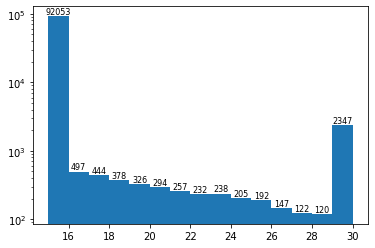

Max 30
Avg 15.550382209867964


In [9]:
%matplotlib inline
import matplotlib.pyplot as plt

counts, bins, patch = plt.hist(hard_neg_nums, bins=15, log=True)
width = bins[1] - bins[0]
for a, b in zip(bins, counts):
    plt.text(a + width / 2, b + 0.05, '%.0f' % b if b > 0 else '', ha='center', va='bottom',fontsize=8)
plt.show()
print(f"Max {max(hard_neg_nums)}")
print(f"Avg {sum(hard_neg_nums) / len(hard_neg_nums)}")

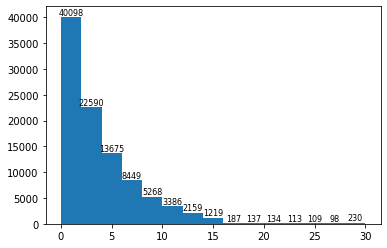

Max 30
Avg 3.416946000081756


In [10]:
counts, bins, patch = plt.hist(in_neighbor_nums, bins=15, log=False)
width = bins[1] - bins[0]
for a, b in zip(bins, counts):
    plt.text(a + width / 2, b + 0.05, '%.0f' % b if b > 0 else '', ha='center', va='bottom',fontsize=8)
plt.show()
print(f"Max {max(in_neighbor_nums)}")
print(f"Avg {sum(in_neighbor_nums) / len(in_neighbor_nums)}")

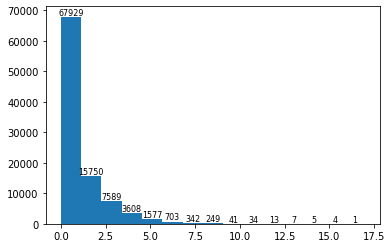

Max 17
Avg 1.186955810816335


In [11]:
counts, bins, patch = plt.hist(out_neighbor_nums, bins=15, log=False)
width = bins[1] - bins[0]
for a, b in zip(bins, counts):
    plt.text(a + width / 2, b + 0.05, '%.0f' % b if b > 0 else '', ha='center', va='bottom',fontsize=8)
plt.show()
print(f"Max {max(out_neighbor_nums)}")
print(f"Avg {sum(out_neighbor_nums) / len(out_neighbor_nums)}")

In [12]:
with open('data/corpus/hotpot-paragraph-5.tsv') as f1, open(f"data/corpus/hotpot-paragraph-5{'.strict' if is_strict else ''}.refined.1.tsv", 'w') as f2:
    f2.write('id\ttext\title\hyperlinks\tsentence_spans\n')
    for line in f1:
        segs = line.strip().split('\t')
        p_id, text, title, hyperlinks, sentence_spans = segs
        p_id, text, title, hyperlinks, sentence_spans = p_id.strip(), text.strip(), title.strip(), hyperlinks.strip(), sentence_spans.strip()
        if p_id == 'id':
            continue
        cleaned_hyperlinks = {
            t: anchors for t, anchors in json.loads(hyperlinks).items() if unescape(t) in title2id
        }
        if p_id in train_dev_p_ids:
            f2.write(f"{p_id}\t{text}\t{title}\t{json.dumps(cleaned_hyperlinks, ensure_ascii=False)}\t{sentence_spans}\n")

In [13]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained('google/electra-base-discriminator', use_fast=True,
                                           additional_special_tokens=['[unused0]', '[unused1]', '[unused2]', '[unused3]'])

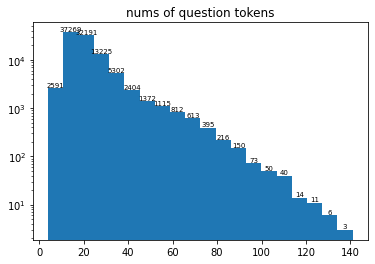

Max 141
Avg 22.22764992028778


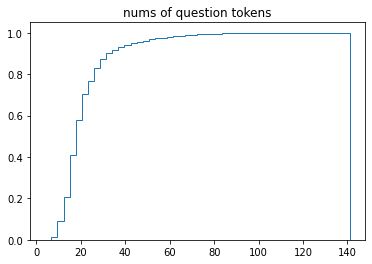

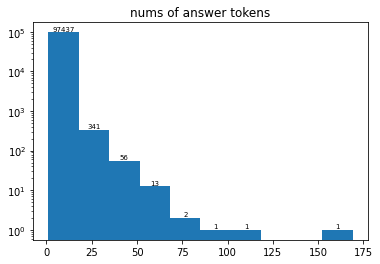

Max 169
Avg 3.127151207946695


In [14]:
from tqdm.auto import tqdm
from utils.data_utils import load_samples

q_token_nums = []
ans_token_nums = []
for q_idx, (q_id, qas) in enumerate(tqdm(load_samples('data/hotpot-train.tsv', test=False) + load_samples('data/hotpot-dev.tsv', test=False))):
    question, answer, sp_facts = qas
    q_token_nums.append(len(tokenizer(question, add_special_tokens=False)['input_ids']))
    ans_token_nums.append(len(tokenizer(answer, add_special_tokens=False)['input_ids']))
    
counts, bins, patch = plt.hist(q_token_nums, bins=20, log=True)
width = bins[1] - bins[0]
for a, b in zip(bins, counts):
    plt.text(a + width / 2, b + 0.05, '%.0f' % b if b > 0 else '', ha='center', va='bottom',fontsize=7)
plt.title('nums of question tokens')
plt.show()
print(f"Max {max(q_token_nums)}")
print(f"Avg {sum(q_token_nums) / len(q_token_nums)}")

plt.hist(q_token_nums, bins=50, cumulative=True, density=True, histtype='step')
plt.title('nums of question tokens')
plt.show()

counts, bins, patch = plt.hist(ans_token_nums, bins=10, log=True)
width = bins[1] - bins[0]
for a, b in zip(bins, counts):
    plt.text(a + width / 2, b + 0.05, '%.0f' % b if b > 0 else '', ha='center', va='bottom',fontsize=7)
plt.title('nums of answer tokens')
plt.show()
print(f"Max {max(ans_token_nums)}")
print(f"Avg {sum(ans_token_nums) / len(ans_token_nums)}")